In [441]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [442]:
df  = pd.read_csv('DataBase.csv')
bkp = df
df.head()

,ax,ay,az,gx,gy,gz,time
0,489,-509,-441,2768,-556,15832,0.001803
1,535,-516,-452,2888,-576,15840,0.004631
2,589,-516,-451,2812,-556,15740,0.007350
3,778,-492,-398,2916,-420,15768,0.020295
4,772,-438,-403,2968,-436,15824,0.022999


In [443]:
def normalizeTable(df, key, dt=0.15):
    df[key]  = df[key] - df[key][0] # INICIA NO TEMPO 0
    initTime = df[key].iloc[0]
    finalTime = df[key].iloc[-1] + dt
    newAxis = np.arange(initTime, finalTime, dt)
    df = df.set_index(key).reindex(newAxis, method='ffill')
    return df.reset_index().rename(columns={'index': key})


dt = 0.030
df = normalizeTable(df, 'time', dt)
df.head()

,time,ax,ay,az,gx,gy,gz
0,0.00,489,-509,-441,2768,-556,15832
1,0.03,772,-438,-403,2968,-436,15824
2,0.06,280,-414,-221,2952,-388,16540
3,0.09,-133,-832,-376,2492,-500,16032
4,0.12,-35,-679,-490,2756,-496,15620


In [444]:
xData = df.time.values
yData = df.gx.values

In [445]:
dt = 0.07

# IMPLEMENTANDO OS FILTROS

In [446]:
from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter
import control as ctl

In [447]:
class LaplaceFilter:
    num = []
    den = []
    
    def __init__(self, Ts=1.0, UP=0.1, dt=0.05, Tp=None):
        zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
        Wn   = 4/(zeta*Ts)

        if Tp is not None:
            Wn = np.pi/(Tp*np.sqrt(1 - zeta**2))

        s = ctl.TransferFunction.s
        C = Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)

        C_z = ctl.c2d(C, dt, method='tustin')
        self.num, self.den = self.getFraction(C_z)
        self.Xn = np.zeros_like(self.num)
        self.Yn = np.zeros_like(self.den)
        self.dt = dt

    def getFraction(self, G_z):
        num, den = ctl.tfdata(G_z)
        num = np.squeeze(num)
        den = np.squeeze(den)

        num = num/den[0]
        den = den/den[0]

        if type(num) == np.float64:
            num = np.array([num])

        num = [float(val) for val in num]
        den = [float(val) for val in den]
        return (num, den) 

    def compute(self):
        out = 0.0

        for i in range(0, len(self.num)):
            out += self.Xn[i]*(self.num[i])
        
        for i in range(1, len(self.den)):
            out += self.Yn[i]*(-1*self.den[i])

        return out

    def update(self, input):
        for n in range(len(self.num)-1, 0, -1):
            self.Xn[n] = self.Xn[n-1]

        for n in range(len(self.den)-1, 0, -1):
            self.Yn[n] = self.Yn[n-1]
        
        self.Xn[0] = input
        self.Yn[0] = self.compute()
        return self.Yn[0]
    

filter = LaplaceFilter(Ts=.7, UP=0.01, dt=dt)
yLaplace = np.array([filter.update(val) for val in yData])
yGaussian = gaussian_filter(yData, sigma=10)

order = 2           # Ordem do filtro
cutoff_freq = 0.05  # Frequência de corte (ajuste conforme seu sinal)
b, a = butter(order, cutoff_freq, btype='low', analog=False)
yButter = filtfilt(b, a, yData)

In [448]:
df = pd.DataFrame({
    'laplace': yLaplace,
    'butter': yButter,
    'gaussian': yGaussian,
    'target': (yLaplace + yButter + yGaussian)/3.0,
    'data': yData,
    'time': xData
})

bkp = df.copy()
df

,laplace,butter,gaussian,target,data,time
0,111.233551,2741.175595,2824,1892.136382,2768,0.00
1,485.317191,2740.400383,2825,2016.905858,2968,0.03
2,1044.620532,2738.977348,2825,2202.865960,2952,0.06
3,1585.919192,2736.857773,2826,2382.925655,2492,0.09
4,2005.073941,2734.041200,2827,2522.038381,2756,0.12
...,...,...,...,...,...,...
821,1489.984143,1332.135855,1605,1475.706666,1372,24.63
822,1483.790847,1300.603591,1588,1457.464813,1100,24.66
823,1437.788347,1272.074926,1575,1428.287758,1288,24.69
824,1403.869795,1246.529426,1567,1405.799740,1748,24.72


# ADICIONANDO OS FILTROS

In [449]:
def getStates(df, key, var='y', n=10):
    table = df.copy() 
    table[f'{var}[n-0]'] = table[key]

    for i in range(1, n):
        table[f'{var}[n-{i}]'] = table[key].shift(i)

    table.fillna(0, inplace=True)
    columns = [f'{var}[n-0]'] + [f'{var}[n-{i}]' for i in range(1, n)]
    return table[columns]

size = 3

In [450]:
xButter = getStates(df, 'butter', 'b', size)
xButter.head()

,b[n-0],b[n-1],b[n-2]
0,2741.175595,0.000000,0.000000
1,2740.400383,2741.175595,0.000000
2,2738.977348,2740.400383,2741.175595
3,2736.857773,2738.977348,2740.400383
4,2734.041200,2736.857773,2738.977348


In [451]:
xLaplace = getStates(df, 'laplace', 'l', size)
xLaplace.head()

,l[n-0],l[n-1],l[n-2]
0,111.233551,0.000000,0.000000
1,485.317191,111.233551,0.000000
2,1044.620532,485.317191,111.233551
3,1585.919192,1044.620532,485.317191
4,2005.073941,1585.919192,1044.620532


In [452]:
xGaussian = getStates(df, 'gaussian', 'g', size)
xGaussian.head()

,g[n-0],g[n-1],g[n-2]
0,2824,0.0,0.0
1,2825,2824.0,0.0
2,2825,2825.0,2824.0
3,2826,2825.0,2825.0
4,2827,2826.0,2825.0


In [453]:
df = pd.concat([df.time, xButter, xLaplace, xGaussian, df.target, df.data], axis=1)
df

,time,b[n-0],b[n-1],b[n-2],l[n-0],l[n-1],l[n-2],g[n-0],g[n-1],g[n-2],target,data
0,0.00,2741.175595,0.000000,0.000000,111.233551,0.000000,0.000000,2824,0.0,0.0,1892.136382,2768
1,0.03,2740.400383,2741.175595,0.000000,485.317191,111.233551,0.000000,2825,2824.0,0.0,2016.905858,2968
2,0.06,2738.977348,2740.400383,2741.175595,1044.620532,485.317191,111.233551,2825,2825.0,2824.0,2202.865960,2952
3,0.09,2736.857773,2738.977348,2740.400383,1585.919192,1044.620532,485.317191,2826,2825.0,2825.0,2382.925655,2492
4,0.12,2734.041200,2736.857773,2738.977348,2005.073941,1585.919192,1044.620532,2827,2826.0,2825.0,2522.038381,2756
...,...,...,...,...,...,...,...,...,...,...,...,...
821,24.63,1332.135855,1366.693931,1404.363008,1489.984143,1483.770413,1533.457133,1605,1626.0,1652.0,1475.706666,1372
822,24.66,1300.603591,1332.135855,1366.693931,1483.790847,1489.984143,1483.770413,1588,1605.0,1626.0,1457.464813,1100
823,24.69,1272.074926,1300.603591,1332.135855,1437.788347,1483.790847,1489.984143,1575,1588.0,1605.0,1428.287758,1288
824,24.72,1246.529426,1272.074926,1300.603591,1403.869795,1437.788347,1483.790847,1567,1575.0,1588.0,1405.799740,1748


# MODELO PREDITIVO

In [454]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

,b[n-0],b[n-1],b[n-2],l[n-0],l[n-1],l[n-2],g[n-0],g[n-1],g[n-2]
0,2741.175595,0.000000,0.000000,111.233551,0.000000,0.000000,2824,0.0,0.0
1,2740.400383,2741.175595,0.000000,485.317191,111.233551,0.000000,2825,2824.0,0.0
2,2738.977348,2740.400383,2741.175595,1044.620532,485.317191,111.233551,2825,2825.0,2824.0
3,2736.857773,2738.977348,2740.400383,1585.919192,1044.620532,485.317191,2826,2825.0,2825.0
4,2734.041200,2736.857773,2738.977348,2005.073941,1585.919192,1044.620532,2827,2826.0,2825.0


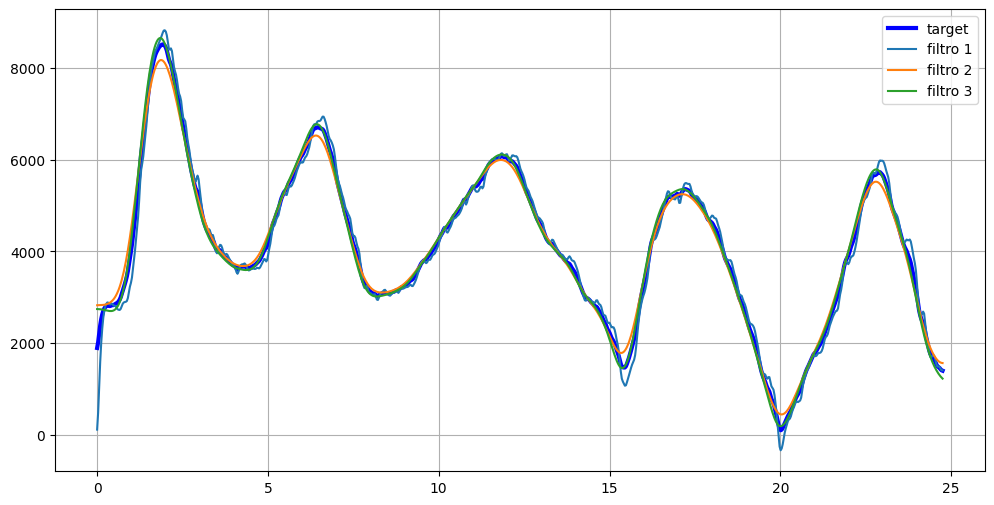

In [455]:
xData = df.drop(columns=['time', 'target', 'data'])
yData = df.target.values
display(xData.head())

plt.figure(figsize=(12, 6))
plt.plot(df.time, yData, label='target', color='blue', linewidth=3)
plt.plot(df.time, bkp.laplace, label='filtro 1')
plt.plot(df.time, bkp.gaussian, label='filtro 2')
plt.plot(df.time, bkp.butter, label='filtro 3')
plt.legend(), plt.grid()
plt.show()

### REGRESSÃO LINEAR

score: 1.000
[ 3.33333333e-01  1.14075416e-14 -5.75928194e-15  3.33333333e-01
 -1.43635104e-15  2.84494650e-16  3.33333333e-01 -1.16087695e-14
  5.46784840e-15] 8.185452315956354e-12


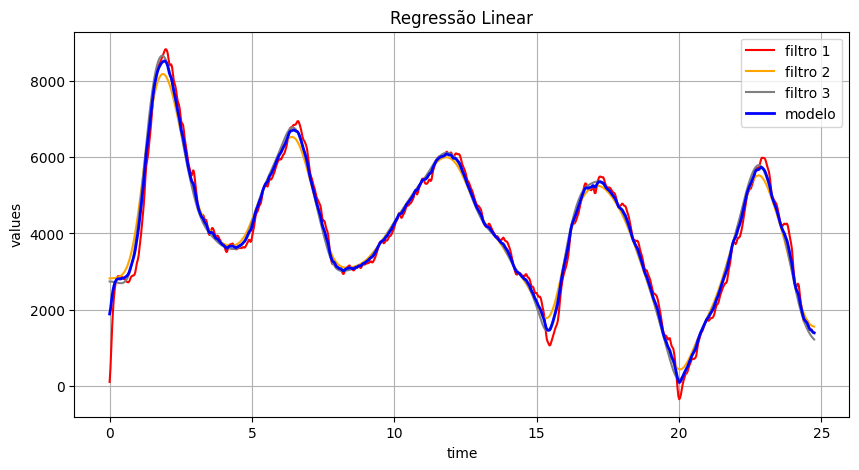

In [456]:
def linearRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = LinearRegression()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = linearRegression(xData, yData)
print(f'score: {score:.3f}')
print(model.coef_, model.intercept_)

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, bkp.laplace, label='filtro 1', color='red')
plt.plot(df.time, bkp.gaussian, label='filtro 2', color='orange')
plt.plot(df.time, bkp.butter, label='filtro 3', color='gray')
plt.plot(df.time, yModel, label='modelo', color='blue', linewidth=2)
plt.xlabel('time'), plt.ylabel('values'), plt.legend(), plt.title('Regressão Linear')
plt.grid()

### REGRESSÃO POLINOMIAL

score: 1.000


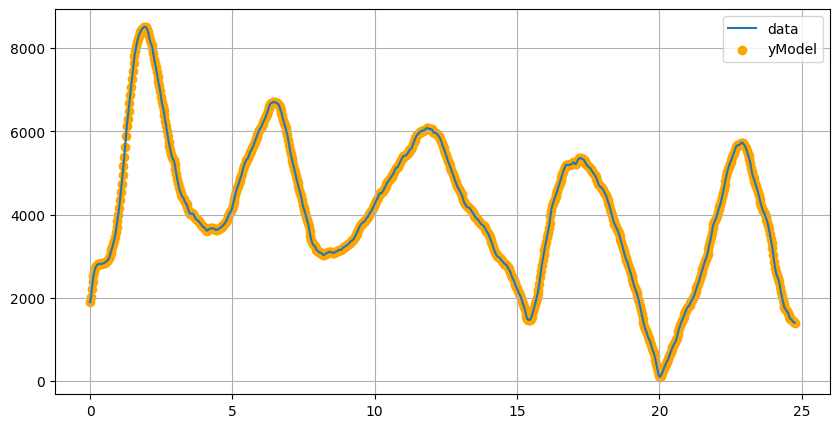

In [457]:
def polinomialRegression(xData, yData, degree=2):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = polinomialRegression(xData, yData, degree=2)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='data')
plt.scatter(df.time, yModel, color='orange', label='yModel')
plt.legend(), plt.grid()
plt.show()

### ÁRVORE DE DECISÃO

score: 0.999


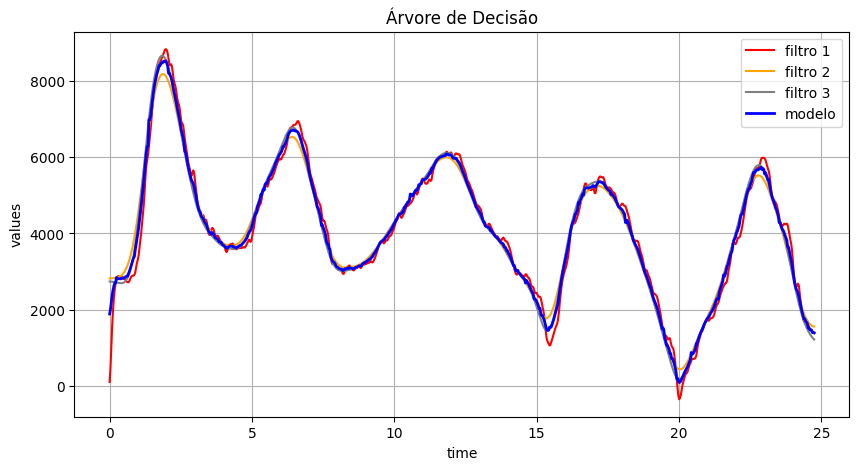

In [458]:
def decisionTreeRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = DecisionTreeRegressor()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = decisionTreeRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, bkp.laplace, label='filtro 1', color='red')
plt.plot(df.time, bkp.gaussian, label='filtro 2', color='orange')
plt.plot(df.time, bkp.butter, label='filtro 3', color='gray')
plt.plot(df.time, yModel, label='modelo', color='blue', linewidth=2)
plt.xlabel('time'), plt.ylabel('values'), plt.legend(), plt.title('Árvore de Decisão')
plt.grid()

### RANDOM FOREST

score: 0.998


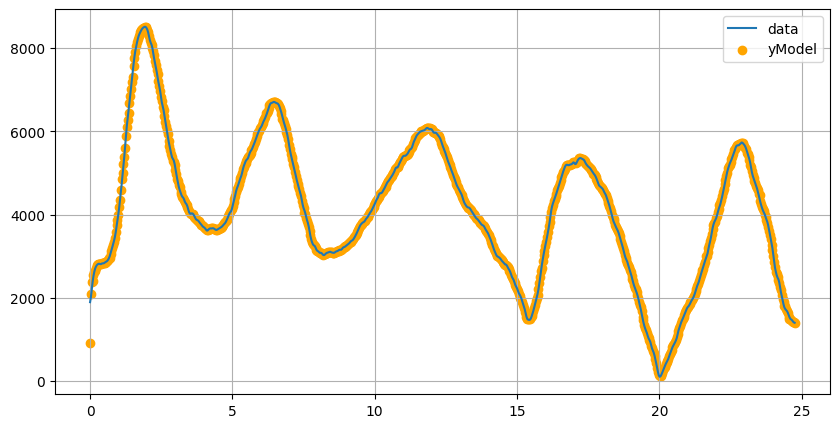

In [459]:
def randomForestRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = RandomForestRegressor()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = randomForestRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='data')
plt.scatter(df.time, yModel, color='orange', label='yModel')
plt.legend(), plt.grid()
plt.show()

### SUPORTE VETORIAL PARA REGRESSÃO (SVR)

score: 0.122


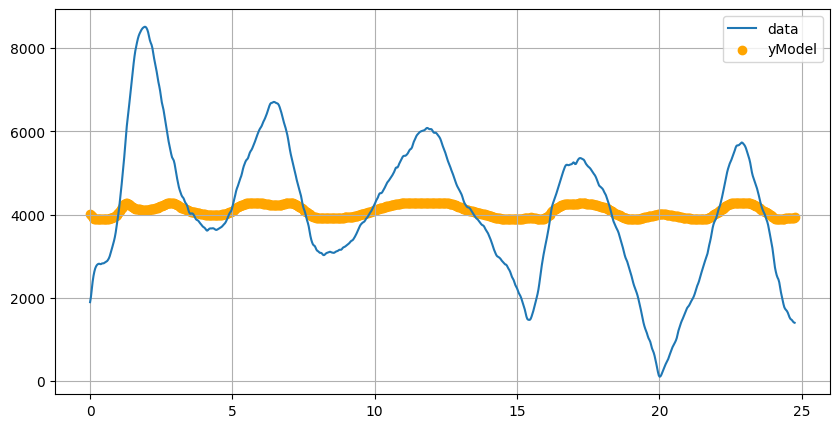

In [460]:
def supportVectorRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = SVR(kernel='rbf')  # kernel pode ser 'linear', 'poly', ou 'rbf'
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = supportVectorRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='data')
plt.scatter(df.time, yModel, color='orange', label='yModel')
plt.legend(), plt.grid()
plt.show()

### RIDGE REGRESSOR

score: 1.000


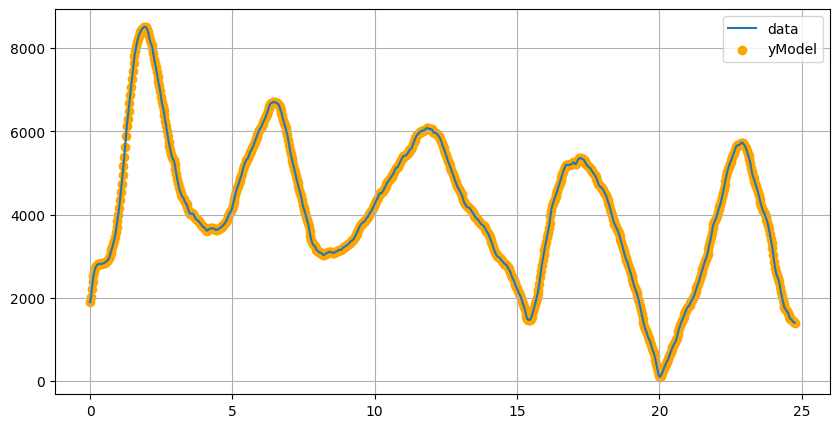

In [461]:
def ridgeRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = Ridge(alpha=1.0)  # Ajuste o parâmetro alpha para regularização
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = ridgeRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='data')
plt.scatter(df.time, yModel, color='orange', label='yModel')
plt.legend(), plt.grid()
plt.show()

### GRADIENT BOOSTER

score: 0.999


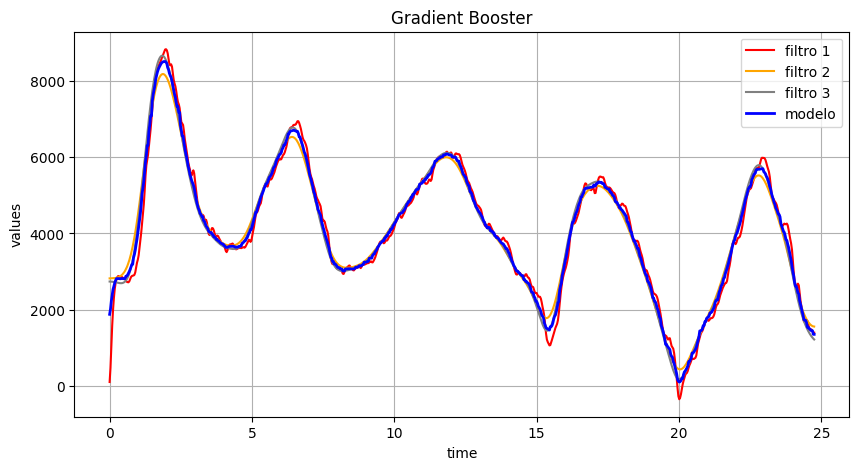

In [462]:
def gradientBoostingRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = gradientBoostingRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, bkp.laplace, label='filtro 1', color='red')
plt.plot(df.time, bkp.gaussian, label='filtro 2', color='orange')
plt.plot(df.time, bkp.butter, label='filtro 3', color='gray')
plt.plot(df.time, yModel, label='modelo', color='blue', linewidth=2)
plt.xlabel('time'), plt.ylabel('values'), plt.legend(), plt.title('Gradient Booster')
plt.grid()

### K-NEAREST NEIGHBORS

score: 0.999


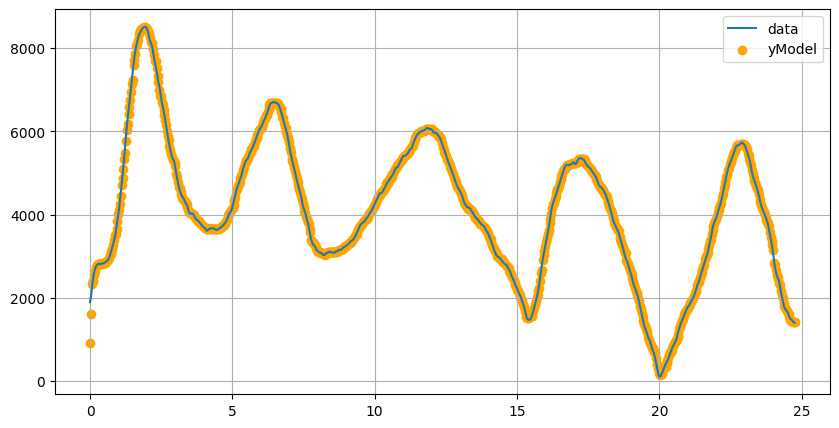

In [463]:
def knnRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = KNeighborsRegressor(n_neighbors=5)  # Ajuste n_neighbors conforme necessário
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = knnRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='data')
plt.scatter(df.time, yModel, color='orange', label='yModel')
plt.legend(), plt.grid()
plt.show()

# TESTANDO COM NOVOS DADOS

In [464]:
class StatesUpdater:
    states  = None
    initial = 0
    size    = 0

    def __init__(self, size, initial=0):
        self.initial = initial
        self.size    = size
        self.states  = initial * np.ones(size)
        
    def update(self, value):
        for i in range(self.size-1, 0, -1):
            self.states[i] = self.states[i-1]

        self.states[0] = value
        return self.states
    

states = StatesUpdater(3)
for i in range(1, 5): print(states.update(i))

[1. 0. 0.]
[2. 1. 0.]
[3. 2. 1.]
[4. 3. 2.]


In [465]:
df = pd.read_csv('DataBase.csv')
df.head()

,ax,ay,az,gx,gy,gz,time
0,489,-509,-441,2768,-556,15832,0.001803
1,535,-516,-452,2888,-576,15840,0.004631
2,589,-516,-451,2812,-556,15740,0.007350
3,778,-492,-398,2916,-420,15768,0.020295
4,772,-438,-403,2968,-436,15824,0.022999


In [466]:
columns = xData.columns
columns

Index(['b[n-0]', 'b[n-1]', 'b[n-2]', 'l[n-0]', 'l[n-1]', 'l[n-2]', 'g[n-0]',
       'g[n-1]', 'g[n-2]'],
      dtype='object')

In [467]:
bstates = StatesUpdater(size)
lstates = StatesUpdater(size)
gstates = StatesUpdater(size)
yData   = []

for i, row in df.iterrows():
    butter, laplace, gaussian = row['butter'], row['laplace'], row['gaussian']
    xData  = list(bstates.update(butter)) + list(lstates.update(laplace)) + list(gstates.update(gaussian))
    xData  = pd.DataFrame([xData], columns=columns)
    yData.append(model.predict(xData)[0])


plt.figure(figsize=(10, 5))
plt.plot(df.time, yModel, label='model')
plt.plot(df.time, yData, label='raw model')
plt.legend(), plt.grid(), plt.ylim(3700, 4110)
plt.show()

KeyError: 'butter'

In [ ]:
metrics.r2_score(yData, yModel)

1.0